In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from scipy.stats import entropy as scipy_entropy
import csv

In [2]:
def mean_var(image_channel, mask):
    pixels = image_channel[mask == 255]
    if len(pixels) == 0:
        return 0.0, 0.0
    return np.mean(pixels), np.var(pixels)
def entropy(image_channel, mask):
    pixels = image_channel[mask == 255]
    if len(pixels) < 2:
        return 0.0
    pixels_int = pixels.astype(int)
    pixels_int[pixels_int < 0] = 0
    pixels_int[pixels_int > 255] = 255
    value_counts = np.bincount(pixels_int, minlength=256)
    probabilities = value_counts[value_counts > 0] / len(pixels)
    if len(probabilities) == 0:
        return 0.0
    return scipy_entropy(probabilities, base=2)
def simpan_fitur(nama_file_csv, daftar_nama_kolom, dict_fitur_diekstrak, nilai_label):
    data_baris_untuk_ditulis = []
    for nama_kolom_iter in daftar_nama_kolom:
        if nama_kolom_iter == 'label': 
            data_baris_untuk_ditulis.append(nilai_label)
        else:
            data_baris_untuk_ditulis.append(dict_fitur_diekstrak.get(nama_kolom_iter, 'N/A'))
    try:
        file_sudah_ada = os.path.isfile(nama_file_csv)
        with open(nama_file_csv, mode='a', newline='', encoding='utf-8') as csvfile:
            penulis = csv.writer(csvfile)
            if not file_sudah_ada: 
                penulis.writerow(daftar_nama_kolom)
            penulis.writerow(data_baris_untuk_ditulis)
    except Exception as e:
        pass


--- Memproses Gambar ke-1: NE_1.jpg ---


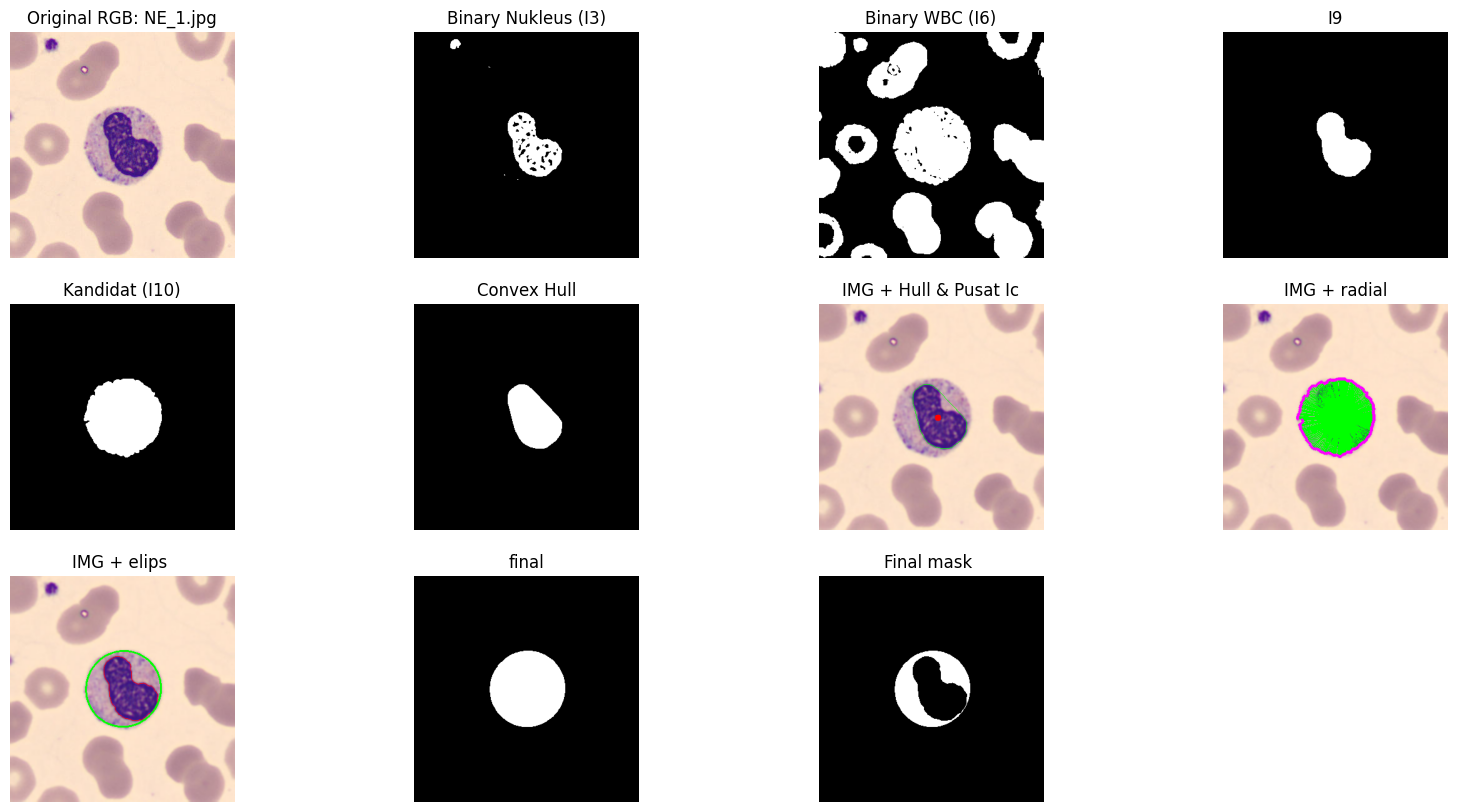


--- Memproses Gambar ke-2: NE_2.jpg ---


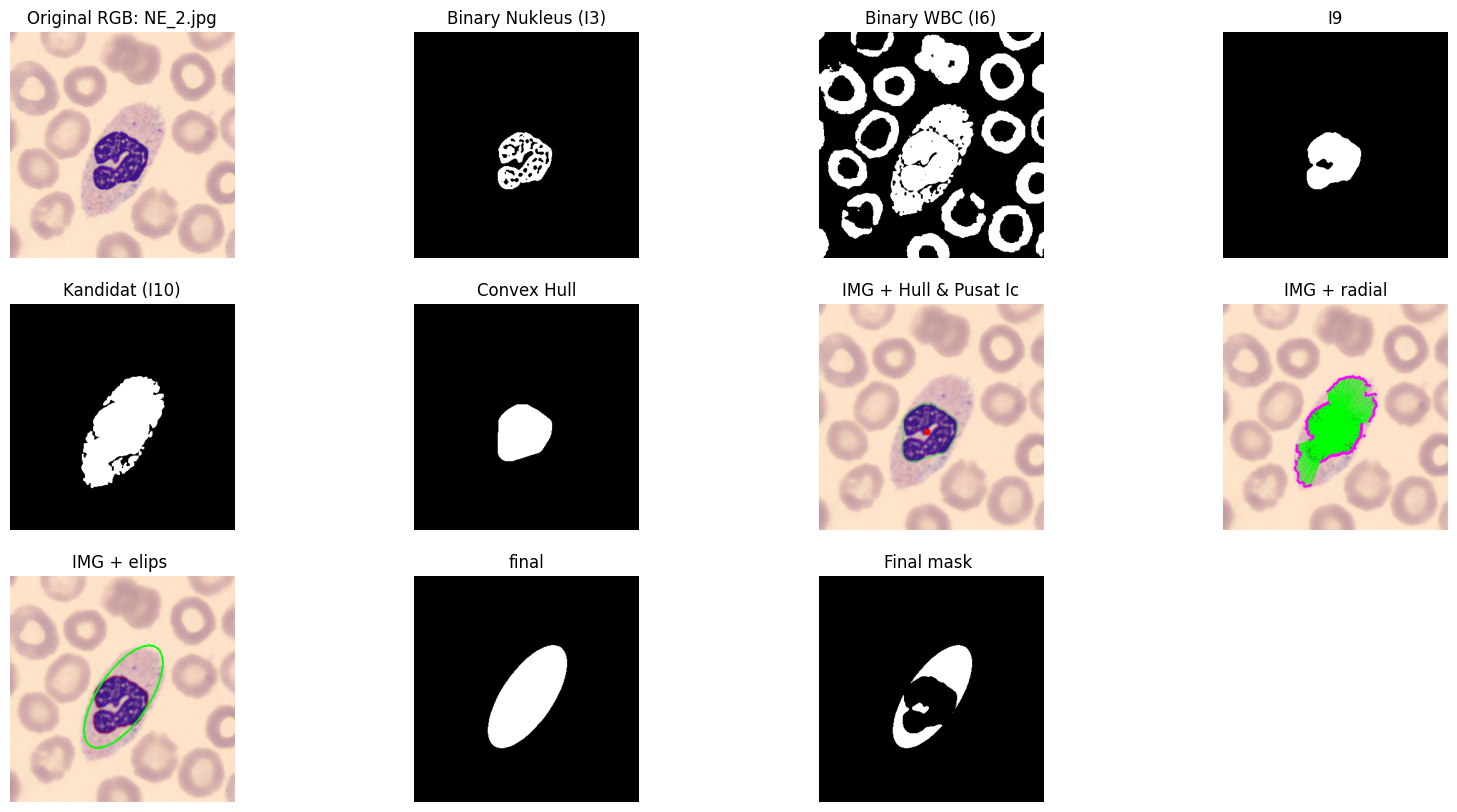


Semua gambar yang dipilih telah diproses (sampai tahap binary dan binary2).


In [3]:
import os
import glob
import re

Label = "neutrophil"
nama_folder_input = fr"C:\Users\dimas\Desktop\STREAMLIT\Cell\{Label}"
path_folder_input = os.path.join(os.getcwd(), nama_folder_input)
tipe_file_gambar = ('*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tif', '*.tiff')
daftar_file_gambar = []
for tipe in tipe_file_gambar:
    daftar_file_gambar.extend(glob.glob(os.path.join(path_folder_input, tipe)))
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]
daftar_file_gambar_terurut = sorted(daftar_file_gambar, key=natural_sort_key)
file_yang_diproses = daftar_file_gambar_terurut[:2]

file_csv = "data_wbc.csv" # Nama file CSV yang akan digunakan
kolom = [
    'nama_file', 'mean_nuc_r', 'var_nuc_r', 'mean_nuc_g', 'var_nuc_g',
    'mean_sito_g', 'var_sito_g', 'cekung', 'ratio_nuc_cell', 'area_nuc',
    'kebulatan', 'entropy_nuc_b', 'entropy_cell_r', 'ratio_mean_cyto_r_b',
    'ratio_mean_cell_r_g', 'ratio_mean_nuc_g_r', 'label'
]
if not os.path.isfile(file_csv):
    with open(file_csv, mode='w', newline='', encoding='utf-8') as csvfile_init:
        writer_init = csv.writer(csvfile_init)
        writer_init.writerow(kolom)
    print(f"File CSV '{file_csv}' telah dibuat dengan header.")

for idx_gambar, path_gambar in enumerate(file_yang_diproses):
    print(f"\n--- Memproses Gambar ke-{idx_gambar + 1}: {os.path.basename(path_gambar)} ---")

    img_bgr_original = cv2.imread(path_gambar)
    if img_bgr_original is None:
        print(f"Error: Tidak bisa membaca gambar {path_gambar}")
        continue

    img_rgb_input = cv2.cvtColor(img_bgr_original, cv2.COLOR_BGR2RGB)
    img = cv2.GaussianBlur(img_rgb_input, (5, 5), 0)
    R = img[..., 0].astype(np.float32)
    G = img[..., 1].astype(np.float32)
    B = img[..., 2].astype(np.float32)

    numerator_nuc = (R + B)
    denominator_nuc = 2 * G + 1e-6
    img_1 = numerator_nuc // denominator_nuc 
    img_1[img_1 == 0] = 1
    img_1[img_1 >= 5] = 5

    img_1n = 255 * (img_1 - np.min(img_1)) / (np.max(img_1) - np.min(img_1))
    img_1n = img_1n.astype(np.uint8)
    equ = cv2.equalizeHist(img_1n)
    _, binary = cv2.threshold(equ, 30, 255, cv2.THRESH_BINARY)


    numerator_wbc = (R + B) 
    denominator_wbc = 2 * G + 1e-6
    img_2 = numerator_wbc / denominator_wbc 
    img_2n = 255 * (img_2 - np.min(img_2)) / (np.max(img_2) - np.min(img_2))
    img_2n = img_2n.astype(np.uint8)
    equ2 = cv2.equalizeHist(img_2n)
    _, binary2 = cv2.threshold(equ2, 170, 255, cv2.THRESH_BINARY)

    radius_closing = 3
    kernel_closing = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2 * radius_closing + 1, 2 * radius_closing + 1))
    img_dilated_for_closing = cv2.dilate(binary, kernel_closing, iterations=1)
    img_closed = cv2.erode(img_dilated_for_closing, kernel_closing, iterations=1)

    # 2. Size Checking
    min_nucleus_lobe_area = 670
    img_size_checked = np.zeros_like(img_closed)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img_closed, connectivity=8)

    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_nucleus_lobe_area:
            img_size_checked[labels == i] = 255

    # 3. Hole Filling
    max_hole_area = 220
    I9 = img_size_checked.copy()
    contours_hole_filling, hierarchy_hole_filling = cv2.findContours(I9, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    if hierarchy_hole_filling is not None:
        for i in range(len(contours_hole_filling)):
            if hierarchy_hole_filling[0][i][3] != -1:
                area = cv2.contourArea(contours_hole_filling[i])
                if area < max_hole_area and area > 0:
                    cv2.drawContours(I9, [contours_hole_filling[i]], -1, 255, -1)
    
    kernel_opening = np.ones((3,3),np.uint8)
    binary2_clean = cv2.morphologyEx(binary2, cv2.MORPH_OPEN, kernel_opening)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary2_clean,connectivity=8,ltype=cv2.CV_32S)

    daerah_terluas = 0
    label_terbaik = -1
    for i in range(1, num_labels):
        daerah = (labels == i).astype(np.uint8) * 255
        overlap_with_nucleus = cv2.bitwise_and(daerah, I9)
        current_overlap_area = np.sum(overlap_with_nucleus) / 255
        if current_overlap_area > daerah_terluas:
            daerah_terluas = current_overlap_area
            label_terbaik = i

    Kandidat_awal = np.zeros_like(labels, dtype=np.uint8)
    if label_terbaik != -1:
        Kandidat_awal = (labels == label_terbaik).astype(np.uint8) * 255

    # Hole filling pada Kandidat_awal
    I10 = Kandidat_awal.copy()
    if np.sum(Kandidat_awal) > 0: # Lakukan hole filling hanya jika ada kandidat
        max_hole_area_kandidat = 220 # Bisa disesuaikan atau menggunakan parameter yang sama
        contours_kandidat, hierarchy_kandidat = cv2.findContours(I10, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
        if hierarchy_kandidat is not None:
            for i in range(len(contours_kandidat)):
                if hierarchy_kandidat[0][i][3] != -1:
                    area = cv2.contourArea(contours_kandidat[i])
                    if area < max_hole_area_kandidat and area > 0:
                        cv2.drawContours(I10, [contours_kandidat[i]], -1, 255, -1)


    # convex hull
    contours_nucleus, _ = cv2.findContours(I9, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    convex_hull = np.zeros_like(I9)

    titik_tengah = None
    paku = None
    nucleus_contour= None

    if contours_nucleus:
        cnt_n = max(contours_nucleus, key=cv2.contourArea)
        nucleus_contour = [cnt_n]
        
        hull_n_points = cv2.convexHull(cnt_n)
        paku = [hull_n_points]
        
        cv2.drawContours(convex_hull, [hull_n_points], -1, 255, thickness=cv2.FILLED)

        M_n = cv2.moments(hull_n_points)
        if M_n["m00"] != 0:
            cx_n = int(M_n["m10"] / M_n["m00"])
            cy_n = int(M_n["m01"] / M_n["m00"])
            titik_tengah = (cx_n, cy_n)
        else:
            M_cnt_n = cv2.moments(cnt_n)
            if M_cnt_n["m00"] != 0:
                cx_n = int(M_cnt_n["m10"] / M_cnt_n["m00"])
                cy_n = int(M_cnt_n["m01"] / M_cnt_n["m00"])
                titik_tengah = (cx_n, cy_n)
            else:
                print("Centroid nukleus tidak dapat dihitung, menggunakan pusat gambar sebagai fallback.")
                h_shape, w_shape = I9.shape
                titik_tengah = (w_shape // 2, h_shape // 2)
    else:
        print("Tidak ada kontur nukleus ditemukan di hole_filled_mask untuk membuat convex hull.")
        h_shape, w_shape = I9.shape
        titik_tengah = (w_shape // 2, h_shape // 2)
        paku = []
        nucleus_contour = []
    # untuk visualisasi
    img_rgb_display = img.copy()
    img_convex = img_rgb_display.copy()
    if paku: 
        cv2.drawContours(img_convex, paku, -1, (0, 255, 0), 1) # Hijau
    if titik_tengah: 
        cv2.circle(img_convex, titik_tengah, 5, (255, 0, 0), -1) # Merah



    canny = cv2.Canny(I10, 50, 150)
    kernel = np.ones((3, 3), np.uint8)
    canny_dilasi = cv2.dilate(canny, kernel, iterations=1)

    major = 0
    if paku and len(paku[0]) >= 5:
        points = paku[0]
        try:
            if points.ndim == 3 and points.shape[1] == 1:
                points = points.astype(np.float32)
            elif points.ndim == 2:
                points = points.reshape(-1, 1, 2).astype(np.float32)
            else:
                raise ValueError("Format titik hull tidak sesuai.")
            ellipse_params = cv2.fitEllipse(points)
            axis1, axis2 = ellipse_params[1]
            major = int(max(axis1, axis2))

        except (cv2.error, ValueError) as e:
            print(f"[fitEllipse ERROR] {e}")
            major = 0
    else:
        if not paku:
            print("[INFO] Tidak ada convex hull.")
        elif len(paku[0]) < 5:
            print(f"[INFO] Titik hull kurang dari 5: {len(paku[0])}")
        major = 0

    # 4. Fallback estimasi dari area jika gagal
    if major == 0 and np.sum(I9) > 0:
        area_nuc = np.sum(I9 > 0)
        major = int(2 * np.sqrt(area_nuc / np.pi))
        if major < 5:
            major = 10
            print(f"[Fallback] Estimasi terlalu kecil, diset ke minimum: {major}")


    canny_input_for_radial = canny_dilasi
    if I10.dtype != np.uint8: I10 = I10.astype(np.uint8)
    if np.any((I10 != 0) & (I10 != 255)): I10[I10 > 0] = 255
    img_rgb_display = img.copy()
    height, width = img.shape[:2]

    # titik tengah 
    (cx_n, cy_n) = titik_tengah
    major = major
    garis = 360 
    boundary_points = []
    img_radial = img_rgb_display.copy()

    for i in range(garis):
        angle_degrees = i * (360.0 / garis)
        angle_radians = np.deg2rad(angle_degrees)
        found_point_on_line = None 
        
        # Iterasi dari pusat ke luar sepanjang garis radial
        for r_step in range(1, major + 1): 
            x = int(round(cx_n + r_step * np.cos(angle_radians)))
            y = int(round(cy_n + r_step * np.sin(angle_radians)))
            if not (0 <= x < width and 0 <= y < height):
                break 
            if canny_input_for_radial[y, x] > 0:
                found_point_on_line = (x, y)
                break
        if found_point_on_line:
            boundary_points.append(found_point_on_line)
            cv2.line(img_radial, (cx_n, cy_n), found_point_on_line, (0, 255, 0), 1)
    for point in boundary_points:
        cv2.circle(img_radial, point, 2, (255, 0, 255), -1) 



    # Ellipse Fitting ---
    Final_Wbc = np.zeros_like(I10)
    elips = None
    hull_cand_fallback_for_ellipse_viz = None
    if boundary_points and len(boundary_points) >= 5:
        try:
            np_boundary_points = np.array(boundary_points, dtype=np.float32)
            if np_boundary_points.ndim == 2:
                np_boundary_points = np_boundary_points.reshape(-1, 1, 2)
            
            elips = cv2.fitEllipse(np_boundary_points)
            cv2.ellipse(Final_Wbc, elips, (255), thickness=cv2.FILLED)
        except cv2.error as e:
            elips = None
        except Exception as e:
            elips = None
    else:
        pass
    final_cytoplasm_mask = cv2.bitwise_and(Final_Wbc, cv2.bitwise_not(I9))
    img_elips = img_rgb_display.copy()
    I9_kontur, _ = cv2.findContours(I9, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img_elips, I9_kontur, -1, (255,0,0), 1)
    cv2.ellipse(img_elips, elips, (0,255,0), 2)

    plt.figure(figsize=(20,10))
    plt.subplot(3, 4, 1)
    plt.imshow(img_rgb_input) 
    plt.title(f"Original RGB: {os.path.basename(path_gambar)}")
    plt.axis('off')

    plt.subplot(3, 4, 2)
    plt.imshow(binary, cmap='gray')
    plt.title("Binary Nukleus (I3)")
    plt.axis('off')

    plt.subplot(3, 4, 3)
    plt.imshow(binary2, cmap='gray')
    
    plt.title("Binary WBC (I6)")
    plt.axis('off')

    plt.subplot(3, 4, 4)
    plt.imshow(I9, cmap='gray')
    plt.title("I9")
    plt.axis('off')

    plt.subplot(3, 4, 5)
    plt.imshow(I10, cmap='gray')
    plt.title("Kandidat (I10)")
    plt.axis('off')

    plt.subplot(3, 4, 6)
    plt.imshow(convex_hull, cmap='gray')
    plt.title("Convex Hull")
    plt.axis('off')

    plt.subplot(3, 4, 7)
    plt.imshow(img_convex)
    plt.title("IMG + Hull & Pusat Ic")
    plt.axis('off')

    plt.subplot(3, 4, 8)
    plt.imshow(img_radial)
    plt.title("IMG + radial")
    plt.axis('off')

    plt.subplot(3, 4, 9)
    plt.imshow(img_elips)
    plt.title("IMG + elips ")
    plt.axis('off')

    plt.subplot(3, 4, 10)
    plt.imshow(Final_Wbc,cmap='gray')
    plt.title("final")
    plt.axis('off')

    plt.subplot(3, 4, 11)
    plt.imshow(final_cytoplasm_mask,cmap='gray')
    plt.title("Final mask ")
    plt.axis('off')

    
    plt.show()



    if 'I9' in locals() and I9.dtype != np.uint8: I9 = I9.astype(np.uint8)
    if 'I9' in locals() and np.any((I9 != 0) & (I9 != 255)): I9[I9 > 0] = 255
    if 'Final_Wbc' in locals() and Final_Wbc.dtype != np.uint8: Final_Wbc = Final_Wbc.astype(np.uint8)
    if 'Final_Wbc' in locals() and np.any((Final_Wbc != 0) & (Final_Wbc != 255)): Final_Wbc[Final_Wbc > 0] = 255
    if 'final_cytoplasm_mask' in locals() and final_cytoplasm_mask.dtype != np.uint8:
        final_cytoplasm_mask = final_cytoplasm_mask.astype(np.uint8)
    if 'final_cytoplasm_mask' in locals() and np.any((final_cytoplasm_mask != 0) & (final_cytoplasm_mask != 255)):
        final_cytoplasm_mask[final_cytoplasm_mask > 0] = 255
    R_channel = img_rgb_display[:,:,0]
    G_channel = img_rgb_display[:,:,1]
    B_channel = img_rgb_display[:,:,2]

    # Inisialisasi dictionary untuk menyimpan fitur
    fitur_diekstrak = {}

    # nama_file
    img_filename=os.path.basename(path_gambar)
    fitur_diekstrak['nama_file'] = img_filename if 'img_filename' in locals() else "NamaFileTidakAda"

    # 1. mean_nuc_r
    mean_nuc_r_val, _ = mean_var(R_channel, I9)
    fitur_diekstrak['mean_nuc_r'] = mean_nuc_r_val

    # 2. var_nuc_r
    _, var_nuc_r_val = mean_var(R_channel, I9)
    fitur_diekstrak['var_nuc_r'] = var_nuc_r_val

    # 3. mean_nuc_g
    mean_nuc_g_val, _ = mean_var(G_channel, I9)
    fitur_diekstrak['mean_nuc_g'] = mean_nuc_g_val

    # 4. var_nuc_g
    _, var_nuc_g_val = mean_var(G_channel, I9)
    fitur_diekstrak['var_nuc_g'] = var_nuc_g_val

    # 5. mean_sito_g
    mean_sito_g_val, _ = mean_var(G_channel, final_cytoplasm_mask)
    fitur_diekstrak['mean_sito_g'] = mean_sito_g_val

    # 6. var_sito_g
    _, var_sito_g_val = mean_var(G_channel, final_cytoplasm_mask)
    fitur_diekstrak['var_sito_g'] = var_sito_g_val

    # 7. cekung (Jumlah titik cekung pada nukleus)
    num_concavities = 0
    if 'I9' in locals() and I9 is not None and np.sum(I9) > 0:
        contours_nuc, _ = cv2.findContours(I9, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours_nuc:
            cnt_n = max(contours_nuc, key=cv2.contourArea)
            if len(cnt_n) >= 5:
                if cnt_n.ndim == 2:
                    cnt_n_reshaped = cnt_n.reshape(-1,1,2)
                else:
                    cnt_n_reshaped = cnt_n
                try:
                    hull_indices = cv2.convexHull(cnt_n_reshaped, returnPoints=False)
                    if hull_indices is not None and len(hull_indices) > 2:
                        defects = cv2.convexityDefects(cnt_n_reshaped, hull_indices)
                        if defects is not None:
                            num_concavities = defects.shape[0]
                except cv2.error:
                    num_concavities = 0
    fitur_diekstrak['cekung'] = num_concavities

    # 8. ratio_nuc_cell (Rasio area nukleus terhadap area sel)
    area_nuc_val = np.sum(I9 == 255)
    area_cell_val = np.sum(Final_Wbc == 255) # REVISI: Menggunakan Final_Wbc untuk area sel
    fitur_diekstrak['ratio_nuc_cell'] = area_nuc_val / area_cell_val if area_cell_val > 0 else 0.0

    # 9. area_nuc (Area nukleus)
    fitur_diekstrak['area_nuc'] = float(area_nuc_val)

    # 10. kebulatan (Roundness sel)
    roundness_cell_val = 0.0
    if area_cell_val > 0: # Menggunakan area_cell_val yang sudah dihitung dari Final_Wbc
        contours_cell, _ = cv2.findContours(Final_Wbc, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # REVISI: Menggunakan Final_Wbc
        if contours_cell:
            cnt_cell = max(contours_cell, key=cv2.contourArea)
            perimeter_cell = cv2.arcLength(cnt_cell, True)
            if perimeter_cell > 0:
                roundness_cell_val = (4 * np.pi * area_cell_val) / (perimeter_cell**2)
    fitur_diekstrak['kebulatan'] = roundness_cell_val

    # 11. entropy_nuc_b (Entropi nukleus pada kanal biru)
    entropy_nuc_b_val = entropy(B_channel, I9)
    fitur_diekstrak['entropy_nuc_b'] = entropy_nuc_b_val

    # 12. entropy_cell_r (Entropi sel pada kanal merah)
    entropy_cell_r_val = entropy(R_channel, Final_Wbc) 
    fitur_diekstrak['entropy_cell_r'] = entropy_cell_r_val

    # 13. ratio_mean_cyto_r_b (Rasio mean R/B sitoplasma)
    mean_cyto_r_val, _ = mean_var(R_channel, final_cytoplasm_mask)
    mean_cyto_b_val, _ = mean_var(B_channel, final_cytoplasm_mask)
    fitur_diekstrak['ratio_mean_cyto_r_b'] = mean_cyto_r_val / mean_cyto_b_val if mean_cyto_b_val > 0 else 0.0

    # 14. ratio_mean_cell_r_g (Rasio mean R/G sel)
    mean_cell_r_val, _ = mean_var(R_channel, Final_Wbc) 
    mean_cell_g_val, _ = mean_var(G_channel, Final_Wbc) 
    fitur_diekstrak['ratio_mean_cell_r_g'] = mean_cell_r_val / mean_cell_g_val if mean_cell_g_val > 0 else 0.0

    # 15. ratio_mean_nuc_g_r (Rasio mean G/R nukleus)
    fitur_diekstrak['ratio_mean_nuc_g_r'] = mean_nuc_g_val / mean_nuc_r_val if mean_nuc_r_val > 0 else 0.0

    # simpan_fitur(nama_file_csv=file_csv,daftar_nama_kolom=kolom,dict_fitur_diekstrak=fitur_diekstrak,nilai_label=Label)


print("\nSemua gambar yang dipilih telah diproses (sampai tahap binary dan binary2).")